# Plume Analysis Walkthrough

This notebook provides a step-by-step guide to understanding the `plumes_analyzer.py` script. We will walk through the process of calculating methane emission rates and their uncertainties from satellite-derived concentration maps. Each step is accompanied by explanations and the corresponding mathematical formulations.

## 1. Setup and Imports

First, let's import the necessary libraries. We'll need `numpy` for numerical operations, `gdal` for raster data handling, `geopandas` for vector data (shapefiles), and `matplotlib` for plotting.

In [110]:
import os
import sys
from pathlib import Path
import numpy as np
import math
from osgeo import gdal, ogr, osr
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

# Add the scripts directory to the python path to import the custom modules
NOTEBOOK_ROOT = Path.cwd().resolve()
REPO_ROOT = NOTEBOOK_ROOT.parent
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from scripts import plumes_analyzer

## 2. Configuration and Data Paths

Here, we define the paths to our input data. We will use the output of the `matched_filter_demo_enmap.ipynb` notebook as our starting point. We also define some parameters for the analysis, such as wind speed and sensor type.

In [111]:
BASE_DIR = Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/')
INPUT_DIR = BASE_DIR / 'notebooks' / 'outputs' / 'pipeline_demo' / 'enmap'
OUTPUT_DIR = BASE_DIR / 'notebooks' / 'outputs' / 'plume_analysis_walkthrough'
OUTPUT_DIR.mkdir(exist_ok=True)

CONCENTRATION_FILE = INPUT_DIR / 'L1B_DT0000004147_002_20221002T074833Z_20221002T074837Z_MF.tif'
UNCERTAINTY_FILE = INPUT_DIR / 'L1B_DT0000004147_002_20221002T074833Z_20221002T074837Z_MF_uncertainty.tif'
SHAPEFILE_PATH = INPUT_DIR / 'plumes_mask.shp'
# Analysis parameters
U10 = 7.0
SIGMA_U10 = 1.5
SENSOR_TYPE = 'ENMAP'
GSD = 30

## 3. Visualize Input Data

Let's visualize the concentration and uncertainty maps to get an idea of the data we are working with.

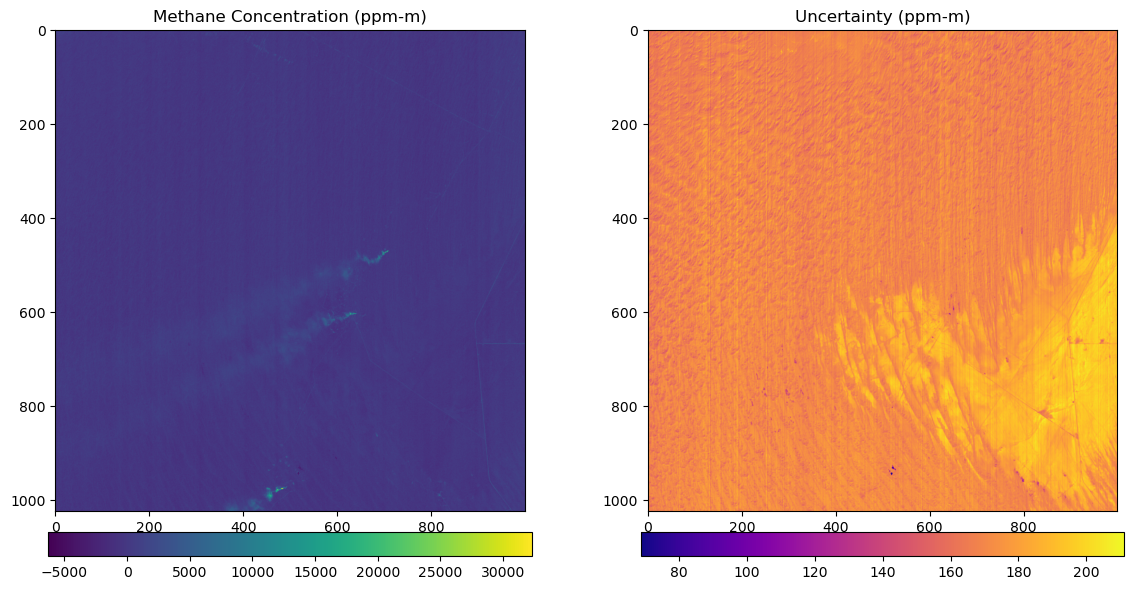

In [112]:
conc_arr, geotransform, projection, _ = plumes_analyzer.load_geotiff(str(CONCENTRATION_FILE))
unc_arr, _, _, _ = plumes_analyzer.load_geotiff(str(UNCERTAINTY_FILE))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

im1 = ax1.imshow(conc_arr, cmap='viridis')
ax1.set_title('Methane Concentration (ppm-m)')
fig.colorbar(im1, ax=ax1, orientation='horizontal', fraction=0.046, pad=0.04)

im2 = ax2.imshow(unc_arr, cmap='plasma')
ax2.set_title('Uncertainty (ppm-m)')
fig.colorbar(im2, ax=ax2, orientation='horizontal', fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

## 4. Load the Segmented Plume Polygons

The matched filter pipeline may produce multiple plume polygons. We load the shapefile, project it to a local UTM CRS for area measurements, and prepare a record for each plume that will be analyzed in the following steps.

Loaded 2 plume polygon(s) from plumes_mask.shp
Shapefile CRS: EPSG:4326
Projected CRS for area calculations: EPSG:32640


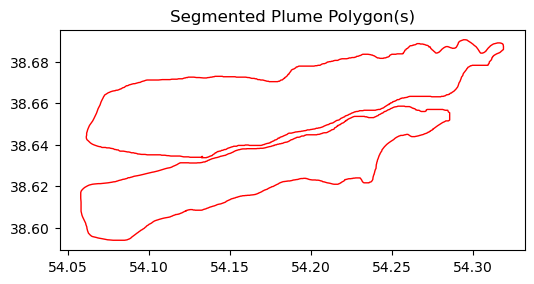

In [113]:
if not SHAPEFILE_PATH.exists():
    raise FileNotFoundError(f'Plume shapefile not found: {SHAPEFILE_PATH}')

gdf = gpd.read_file(SHAPEFILE_PATH)
projected_gdf, projected_epsg = plumes_analyzer.project_gdf_to_local_utm(gdf)

plume_records = []
for (idx, row), (_, proj_row) in zip(gdf.iterrows(), projected_gdf.iterrows()):
    plume_records.append({
        'plume_id': idx,
        'geom': row.geometry,
        'projected_geom': proj_row.geometry
    })

print(f'Loaded {len(plume_records)} plume polygon(s) from {SHAPEFILE_PATH.name}')
print(f'Shapefile CRS: {gdf.crs}')
print(f'Projected CRS for area calculations: EPSG:{projected_epsg}')

ax = gdf.plot(edgecolor='red', facecolor='none', figsize=(6, 6))
ax.set_title('Segmented Plume Polygon(s)')
plt.show()


## 5. Unit Conversion

The input data is in `ppm-m` (parts per million-meter), but the IME calculation requires `ppb` (parts per billion). We convert the concentration and uncertainty values from `ppm-m` to `ppb` once here, and these arrays serve as the starting point for every plume-specific calculation.


In [114]:
conc_clean = plumes_analyzer.discard_neg(conc_arr)
unc_clean = plumes_analyzer.discard_neg(unc_arr)

conc_ppb = plumes_analyzer.ppm_m_to_ppb(conc_clean)
unc_ppb = plumes_analyzer.ppm_m_to_ppb(unc_clean)

print(f'Original max concentration: {np.max(conc_arr):.2f} ppm-m')
print(f'Converted max concentration: {np.max(conc_ppb):.2f} ppb')


Original max concentration: 32298.81 ppm-m
Converted max concentration: 4037.35 ppb


## 6. Clipping the Rasters for Each Plume

For each polygon in the plume mask we clip the concentration and uncertainty rasters, keeping only positive values. This yields one pair of maps per plume that we will use for statistics, IME, and flux estimates.


/home/esivla/miniconda3/envs/hygasMF/lib/python3.11/site-packages/osgeo/gdal.py:9374: RuntimeWarning: the source raster dataset has a SRS, but the cutline features not.  We assume that the cutline coordinates are expressed in the destination SRS. If not, cutline results may be incorrect.
  return _gdal.wrapper_GDALWarpDestName(*args)


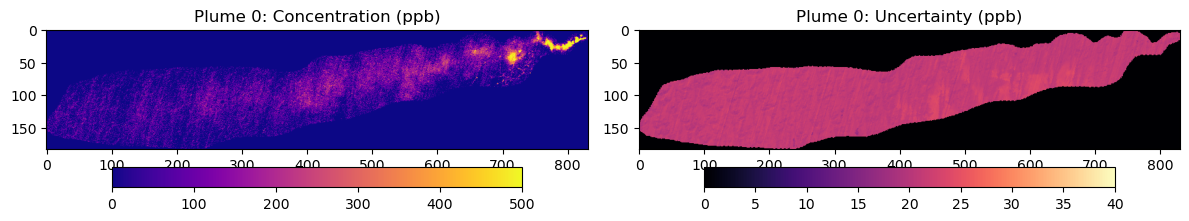

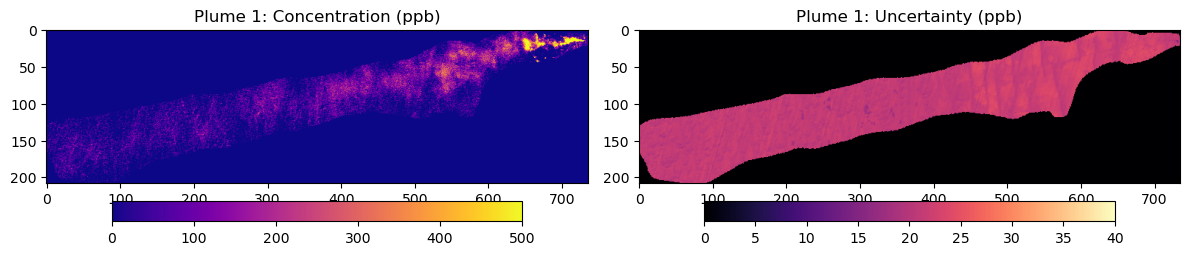

In [115]:
plume_outputs = []
for record in plume_records:
    plume_id = record['plume_id']
    conc_out = OUTPUT_DIR / f'clipped_conc_plume_{plume_id}.tif'
    unc_out = OUTPUT_DIR / f'clipped_unc_plume_{plume_id}.tif'
    clipped_conc_arr = plumes_analyzer.clip_raster_to_polygon(
        str(CONCENTRATION_FILE),
        record['geom'],
        str(conc_out)
    )
    clipped_conc_arr = plumes_analyzer.discard_neg(clipped_conc_arr)

    clipped_unc_arr = plumes_analyzer.clip_raster_to_polygon(
        str(UNCERTAINTY_FILE),
        record['geom'],
        str(unc_out)
    )
    clipped_unc_arr = plumes_analyzer.discard_neg(clipped_unc_arr)

    clipped_conc_ppb = plumes_analyzer.ppm_m_to_ppb(clipped_conc_arr)
    clipped_unc_ppb = plumes_analyzer.ppm_m_to_ppb(clipped_unc_arr)
    plume_stats = plumes_analyzer.compute_plume_stats(clipped_conc_ppb)

    plume_outputs.append({
        'plume_id': plume_id,
        'geom': record['geom'],
        'projected_geom': record['projected_geom'],
        'clipped_conc_ppb': clipped_conc_ppb,
        'clipped_unc_ppb': clipped_unc_ppb,
        'plume_stats': plume_stats
    })

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    im1 = ax1.imshow(clipped_conc_ppb, cmap='plasma', vmin=0, vmax=500)
    ax1.set_title(f'Plume {plume_id}: Concentration (ppb)')
    fig.colorbar(im1, ax=ax1, orientation='horizontal', fraction=0.046, pad=0.04)

    im2 = ax2.imshow(clipped_unc_ppb, cmap='magma', vmin=0, vmax=40)
    ax2.set_title(f'Plume {plume_id}: Uncertainty (ppb)')
    fig.colorbar(im2, ax=ax2, orientation='horizontal', fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


### Plume concentration statistics

We report descriptive statistics for each plume's positive ppb pixels.

In [116]:
for output in plume_outputs:
    stats = output['plume_stats']
    print(f"Plume {output['plume_id']}")
    print(f"  Positive plume pixels: {stats['pixel_count']}")
    print(f"  Min concentration: {stats['min']:.2f} ppb")
    print(f"  Max concentration: {stats['max']:.2f} ppb")
    print(f"  Mean concentration: {stats['mean']:.2f} ppb")
    print(f"  Median concentration: {stats['median']:.2f} ppb")
    print('---')


Plume 0
  Positive plume pixels: 55404
  Min concentration: 0.00 ppb
  Max concentration: 2901.43 ppb
  Mean concentration: 84.38 ppb
  Median concentration: 68.99 ppb
---
Plume 1
  Positive plume pixels: 36223
  Min concentration: 0.00 ppb
  Max concentration: 2892.57 ppb
  Mean concentration: 86.44 ppb
  Median concentration: 66.59 ppb
---


## 7. Integrated Methane Enhancement (IME) Calculation

The Integrated Methane Enhancement (IME) represents the total mass of methane in a plume. For every plume we sum the concentration of all pixels within the clipped mask and multiply by a conversion factor. The formula is:

$$ IME (kg) = \sum_{i=1}^{N} (ppb_i) * k $$
where:
- $ppb_i$ is the methane concentration in ppb for pixel i.
- $N$ is the total number of pixels in the plume.
- $k$ is a conversion factor that depends on the pixel area (GSD), and the molar masses of methane and air.

The conversion factor $k$ is calculated as:

$$ k = (GSD^2) * (\frac{M_{CH4}}{M_{air}}) * 10000 * 10^{-9} $$
where:
- $GSD$ is the ground sample distance in meters.
- $M_{CH4}$ is the molar mass of methane (16.04 g/mol).
- $M_{air}$ is the molar mass of dry air (28.97 g/mol).


In [117]:
for output in plume_outputs:
    ime = plumes_analyzer.calculate_ime(output['clipped_conc_ppb'], GSD)
    output['ime'] = ime
    print(f"Plume {output['plume_id']} IME: {ime:.2f} kg")


Plume 0 IME: 23295.45 kg
Plume 1 IME: 15602.67 kg


## 8. IME Uncertainty Calculation

The uncertainty of the IME is calculated by propagating the uncertainty of each pixel's concentration. Assuming the uncertainties of individual pixels are uncorrelated, the total uncertainty of the IME is the square root of the sum of the squares of the individual uncertainties, multiplied by the same conversion factor k.

$$ \sigma_{IME} (kg) = k * \sqrt{\sum_{i=1}^{N} (\sigma_{ppb,i}^2)} $$
where:
- $\sigma_{ppb,i}$ is the uncertainty of the methane concentration in ppb for pixel i.

In [118]:
for output in plume_outputs:
    sigma_ime = plumes_analyzer.calculate_sigma_ime(output['clipped_unc_ppb'], GSD)
    output['sigma_ime'] = sigma_ime
    print(f"Plume {output['plume_id']} σ_IME: {sigma_ime:.2f} kg")


Plume 0 σ_IME: 28.73 kg
Plume 1 σ_IME: 24.54 kg


## 9. Wind Response and Flux Calculation

The methane flux (Q) is the rate at which methane is emitted. For each plume we use its IME, an effective wind speed ($U_{eff}$), and the length scale ($L$) computed from the plume area. The formula is:

$$ Q (t/h) = \frac{U_{eff} * IME * 3.6}{L} $$
where:
- $U_{eff}$ is the effective wind speed in m/s.
- $IME$ is the integrated methane enhancement in kg.
- $L$ is the length scale of the plume in meters, approximated as the square root of the plume area.
- The factor 3.6 converts from kg/s to t/h.

The effective wind speed $U_{eff}$ is calculated from the wind speed at 10 meters ($U_{10}$) using a sensor-specific linear relationship. Prior to computing each area, we project the plume polygon to a local UTM CRS so measurements are in square meters.



In [119]:
for output in plume_outputs:
    area = output['projected_geom'].area
    L = math.sqrt(area)
    u_eff, a, b = plumes_analyzer.compute_u_eff(U10, SENSOR_TYPE)
    q = plumes_analyzer.compute_flux(output['ime'], u_eff, L)
    output.update({'area': area, 'L': L, 'u_eff': u_eff, 'a': a, 'b': b, 'q': q})
    print(f"Plume {output['plume_id']} Area: {area:.2f} m^2 (Projected EPSG:{projected_epsg})")
    print(f"  Length Scale (L): {L:.2f} m")
    print(f"  Effective Wind Speed (U_eff): {u_eff:.2f} m/s")
    print(f"  Methane Flux (Q): {q:.2f} t/h")
    print('---')


Plume 0 Area: 67578345.99 m^2 (Projected EPSG:32640)
  Length Scale (L): 8220.60 m
  Effective Wind Speed (U_eff): 3.28 m/s
  Methane Flux (Q): 33.46 t/h
---
Plume 1 Area: 48052012.36 m^2 (Projected EPSG:32640)
  Length Scale (L): 6931.96 m
  Effective Wind Speed (U_eff): 3.28 m/s
  Methane Flux (Q): 26.58 t/h
---


## 10. Flux Uncertainty Propagation

The uncertainty in the flux ($\sigma_Q$) is propagated from the uncertainties in the IME ($\sigma_{IME}$) and the wind speed ($\sigma_{U10}$). The total uncertainty is the quadrature sum of the uncertainties from these two sources:

$$ \sigma_Q = \sqrt{\sigma_{Q,IME}^2 + \sigma_{Q,wind}^2} $$
where:
- $\sigma_{Q,IME} = Q * (\frac{\sigma_{IME}}{IME})$ is the flux uncertainty due to IME uncertainty.
- $\sigma_{Q,wind} = Q * (\frac{\sigma_{Ueff}}{U_{eff}})$ is the flux uncertainty due to wind uncertainty.

The uncertainty in the effective wind speed is given by:

$$ \sigma_{Ueff} = |a| * \sigma_{U10} $$


In [120]:
for output in plume_outputs:
    sigma_q, sigma_q_ime, sigma_q_wind = plumes_analyzer.propagate_flux_uncertainty(
        output['q'],
        output['ime'],
        output['sigma_ime'],
        U10,
        SIGMA_U10,
        output['u_eff'],
        output['a']
    )
    output.update({
        'sigma_q': sigma_q,
        'sigma_q_ime': sigma_q_ime,
        'sigma_q_wind': sigma_q_wind
    })
    print(f"Plume {output['plume_id']} Total Flux Uncertainty (σ_Q): ±{sigma_q:.2f} t/h")
    print(f"  - Flux Uncertainty from IME: {sigma_q_ime:.2f} t/h")
    print(f"  - Flux Uncertainty from Wind: {sigma_q_wind:.2f} t/h")
    print('---')


Plume 0 Total Flux Uncertainty (σ_Q): ±5.66 t/h
  - Flux Uncertainty from IME: 0.04 t/h
  - Flux Uncertainty from Wind: 5.66 t/h
---
Plume 1 Total Flux Uncertainty (σ_Q): ±4.50 t/h
  - Flux Uncertainty from IME: 0.04 t/h
  - Flux Uncertainty from Wind: 4.50 t/h
---


## 11. Summary of Results

We now summarize the per-plume metrics (IME, flux, uncertainties, and ppb statistics) so every plume in the shapefile is reported separately.


In [121]:
for output in plume_outputs:
    print('--- Plume Analysis Report ---')
    print(f"Plume ID: {output['plume_id']}")
    print(f"Plume Area: {output['area']:.2f} m^2")
    print(f"Plume Length Scale (L): {output['L']:.2f} m")
    print(f"Wind Speed (U10): {U10:.2f} ± {SIGMA_U10:.2f} m/s")
    print(f"Effective Wind Speed (U_eff): {output['u_eff']:.2f} m/s")
    print('---')
    print(f"Integrated Methane Enhancement (IME): {output['ime']:.2f} ± {output['sigma_ime']:.2f} kg")
    print(f"Methane Flux (Q): {output['q']:.2f} ± {output['sigma_q']:.2f} t/h")
    print(f"  - Contribution from IME uncertainty: {output['sigma_q_ime']:.2f} t/h")
    print(f"  - Contribution from wind uncertainty: {output['sigma_q_wind']:.2f} t/h")
    stats = output['plume_stats']
    print('--- Plume Concentration Stats (ppb) ---')
    print(f"  Pixels: {stats['pixel_count']}")
    print(f"  Min/Max: {stats['min']:.2f} / {stats['max']:.2f} ppb")
    print(f"  Mean/Median: {stats['mean']:.2f} / {stats['median']:.2f} ppb")
    print()


--- Plume Analysis Report ---
Plume ID: 0
Plume Area: 67578345.99 m^2
Plume Length Scale (L): 8220.60 m
Wind Speed (U10): 7.00 ± 1.50 m/s
Effective Wind Speed (U_eff): 3.28 m/s
---
Integrated Methane Enhancement (IME): 23295.45 ± 28.73 kg
Methane Flux (Q): 33.46 ± 5.66 t/h
  - Contribution from IME uncertainty: 0.04 t/h
  - Contribution from wind uncertainty: 5.66 t/h
--- Plume Concentration Stats (ppb) ---
  Pixels: 55404
  Min/Max: 0.00 / 2901.43 ppb
  Mean/Median: 84.38 / 68.99 ppb

--- Plume Analysis Report ---
Plume ID: 1
Plume Area: 48052012.36 m^2
Plume Length Scale (L): 6931.96 m
Wind Speed (U10): 7.00 ± 1.50 m/s
Effective Wind Speed (U_eff): 3.28 m/s
---
Integrated Methane Enhancement (IME): 15602.67 ± 24.54 kg
Methane Flux (Q): 26.58 ± 4.50 t/h
  - Contribution from IME uncertainty: 0.04 t/h
  - Contribution from wind uncertainty: 4.50 t/h
--- Plume Concentration Stats (ppb) ---
  Pixels: 36223
  Min/Max: 0.00 / 2892.57 ppb
  Mean/Median: 86.44 / 66.59 ppb

